# SABBO
Contents:<br>
Kaplan-Meier-Curve


###### tsolve = survivalTime

In [59]:
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np


In [60]:
# Read CSV
csv_file = 'QUBOClusteringData.csv'

originDf = pd.read_csv(csv_file)

originDf.head()
    

,tsolve,alg,nvars,seed,runseed
0,8.0,UEDA,5,1,1
1,7.0,GR,5,1,1
2,13.0,RS,5,1,1
3,73.0,UEDA,5,1,2
4,4.0,GR,5,1,2


### Kaplan-Meier-Curve

In [73]:
# Only keep UEDA
# @Config
algorithm = "UEDA"
nvars = 10

# @function  makeOrigDf creates dataframe with all original Data
# @return: algDf holds columns tsolve, alg, nvars, seed, runseed
def makeOrigDf(algorithm, nvars):
    algDf = originDf[(originDf["alg"] == algorithm) & (originDf["nvars"] == nvars)]
    # algDf = algDf.sort_values(by='tsolve')
    return algDf
makeOrigDf(algorithm, nvars)


# @function makeMNDF creates dataframe with data in form of m-n (m - died, n - still alive)
def makeMNDf(algDf):

    highestRuntime = algDf['tsolve'].max()
    counterQ = algDf['tsolve'].isna().sum()  # Count the number of censored datapoints
    qDict = {highestRuntime : counterQ}


    allTimes = algDf['tsolve'].dropna()         # drop 12 NaN values for var = 10
    tmpDict1 = dict.fromkeys(set(allTimes), 0)
    for time in allTimes:       # number of algorithms terminated at that time
        tmpDict1[time] += 1

    done = 0       # After the first time is passed, one alg is done already
    tmpDict2 = dict.fromkeys(set(allTimes), len(allTimes))                    
    nDict = {0.0 : 0}
    nDict.update(tmpDict2)

    for key, value in tmpDict1.items():
        tmpDict2[key] = tmpDict2[key] - done
        done+=value

    mDict = {0.0 : 0}
    mDict.update(tmpDict1)  # How many algorithms stop per time unit?

    nAlg = len(allTimes)

    nDict = {0.0 : nAlg}
    nDict.update(tmpDict2)  # How many algorithms do run at that time still?

    # print(mDict)
    # print(nDict)

    mDf = pd.DataFrame.from_dict(mDict, orient="index", columns=["m Died"])
    nDf = pd.DataFrame.from_dict(nDict, orient="index", columns=["n Risk"])     # You stay at risk of dying at the time you die
    qDf = pd.DataFrame.from_dict(qDict, orient="index", columns=["q NaN"])

    dfOverall = pd.merge(mDf, nDf, left_index=True, right_index=True, how='outer')
    dfOverall["q NaN"] = 0
    dfOverall.at[highestRuntime, 'q NaN'] = counterQ

    del tmpDict1, tmpDict2
    
        

    return dfOverall


# @function makeKMDict creates the Kaplan-Meier Dictionairy with HAZ, I-HAZ, S(t)
# @param mnDict: Dictionairy with values index, m, n
def makeKMDf(mnDf):
    # Add Haz, I-Haz and S(t) for later comparisions with different models
    dfOverall['HAZ'] = (dfOverall['m Died'] / dfOverall['n Risk'])         # Risk of Dying for time t given that you are alive at time t
    dfOverall['I-HAZ'] = ((1- dfOverall['HAZ']) / dfOverall['n Risk'])     # Risk of Dying at that time
    dfOverall['S(t)'] = (dfOverall['n Risk'] - dfOverall['m Died']) / nAlg # Still alive
    return dfOverall


# @function plotKMDict graphically plots a KMDict
def plotKMDf(KMDf):
    plt.plot(dfOverall.index, dfOverall['S(t)'], label='S(t)')
    plt.title('Kaplan-Meier-Curve')
    plt.xlabel('Survivors')
    plt.ylabel('S(t)')
    plt.legend()
    plt.show()


OrigDf = makeOrigDf(algorithm, nvars)  # Keep OrigDf as a copy
AlgDf = OrigDf
MNDf   = makeMNDf(AlgDf)
MNDf


,m Died,n Risk,q NaN
0.0,0,88,0
3.0,1,88,0
7.0,1,87,0
12.0,1,86,0
16.0,1,85,0
...,...,...,...
328.0,1,5,0
407.0,1,4,0
411.0,1,3,0
416.0,1,2,0


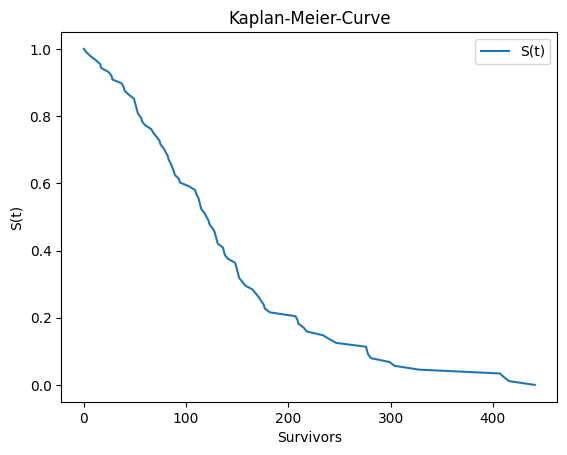

In [74]:
plotKMDict(makeKMDict(makeMNDf(makeOrigDf(algorithm, nvars))))